# Bayes by Backprop
An implementation of the algorithm described in https://arxiv.org/abs/1505.05424.  
This notebook accompanies the article at https://www.nitarshan.com/bayes-by-backprop.

In [15]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [ ]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device", DEVICE)
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.backends.mps.is_available() else {}
print(torch.backends.mps.is_available())

## Data Preparation

In [18]:
BATCH_SIZE = 120
TEST_BATCH_SIZE = 1000


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 600
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

In [19]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [20]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()



class ScaleGaussian(object):
    def __init__(self, pi, sigma1):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.gaussian1 = torch.distributions.Normal(0,sigma1)

    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        return (torch.log(prob1)).sum()
    


$$\pi = \frac{1}{2}$$
$$-\ln{\sigma_1} = 0$$
$$-\ln{\sigma_2} = 6$$

In [21]:
#PI = 0.5
#SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(DEVICE)
#SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(DEVICE)

# BBB prior for 400 units
PI = 0.25
SIGMA_1 = torch.FloatTensor([math.exp(-1)]).to(DEVICE)
SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(DEVICE)


In [22]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, mixture):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.mixture = mixture
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        #self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))

        # BBB
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).normal_(-8, .05))
        
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        #self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))

        # BBB
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).normal_(-8, .05))
    

        self.bias = Gaussian(self.bias_mu, self.bias_rho)

        # Prior distributions
        if self.mixture:
            self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
            self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        else:
            self.weight_prior = ScaleGaussian(PI, SIGMA_1)
            self.bias_prior = ScaleGaussian(PI, SIGMA_1)
        
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [23]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # for breast 28*28 and OUT 2
        # for MNIST and FMINSt 28*28 and OUT 10
        self.l1 = BayesianLinear(28*28, 400, True)
        self.l2 = BayesianLinear(400, 400, True)
        self.l3 = BayesianLinear(400, 10, True)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork().to(DEVICE)

# histograms

In [ ]:
import seaborn as sns
from SGD import *

In [31]:
def collect_weights(model, bnn=False, dvi = False):
    '''Collect all weights from model in a list'''
    mus = []
    rhos = []
    weights = []
    stds=[]
    for name, param in model.named_parameters():
        if 'mu' in name:
            mus.append(param.flatten().tolist())
        elif 'rho' in name:
            rhos.append(param.flatten().tolist())

        elif 'W' in name:
            if 'log' in name:
                stds.append(param.flatten().tolist())
            else:
                mus.append(param.flatten().tolist())
        else:
            weights.append(param.flatten().tolist())
    
    # flatten nested lists
    mus = [item for sublist in mus for item in sublist]
    rhos = [item for sublist in rhos for item in sublist]
    weights = [item for sublist in weights for item in sublist]
    stds = [item for sublist in stds for item in sublist]

    if bnn:
        sigmas = [rho_to_sigma(rho) for rho in rhos]
        weights = [mus, sigmas]

    if dvi:
        weights = [mus, stds]

    return weights

def rho_to_sigma(rho): 
    return np.log(1 + np.exp(rho))

def sample_bnn_weights(mu, sigma):
    return np.random.normal(mu, sigma)

In [27]:
from SGD import *
# 400 units
models = []

model0 = BayesianNetwork()
modelpath0 = 'mnist_400_sgd_constant_xavier_neg2_epoch_400.pth'
model0.load_state_dict(torch.load(modelpath0, map_location='cpu'))
model0.eval()
models.append(model0)

# tuo model
# dovrei avere gia modificato collect weights per funzionare
PATH = './Checkpoints/Fc_variance_epoch_30.pth'
checkpoint = torch.load(PATH)

args = type('', (), {})()
args.var1 = None
args.var2 = None
args.var3 = None
args.var2 = None
args.mcvi = False

from core.models import LinearVariance
model1 = LinearVariance(args=args)
model1.load_state_dict(checkpoint)

model2 = ModelMLP(400, n_input=28*28, n_ouput=10)
modelpath2 = 'Results/SGD/SGD_mnist_mlp_400_0.001_0.95.pth'
model2.load_state_dict(torch.load(modelpath2, map_location='cpu'))
model2.eval()
models.append(model2)

model3 = ModelMLPDropout(400, n_input=28*28, n_ouput=10)
modelpath3 = 'Results/SGD/SGD_mnist_dropout_400_0.001_0.95.pth'
model3.load_state_dict(torch.load(modelpath3, map_location='cpu'))
model3.eval()
models.append(model3)

In [28]:
bnn_mus, bnn_sigmas = collect_weights(model0, bnn=True)
bnn_weights = [sample_bnn_weights(mu, sigma) for mu, sigma in zip(bnn_mus, bnn_sigmas)]

mlp_weights = collect_weights(model2)

dropout_weights = collect_weights(model3)

dvi_mus, dvi_sigmas = collect_weights(model1, dvi=True)
dvi_weights = [sample_bnn_weights(mu, sigma) for mu, sigma in zip(dvi_mus, dvi_sigmas)]

In [29]:
def plot_histogram(weights_list, labels):
    plt.style.use('seaborn-colorblind')
    fig = plt.figure(figsize=(9, 6))
    index = 0

    for weights, label in zip(weights_list, labels):
        sns.kdeplot(weights, label=label, fill=True, clip=[-0.7, 0.7])
        index+=1
    plt.xlim(-0.7, 0.7)
    plt.ylabel('Probability Density', fontsize=20)
    plt.xlabel('Weight', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(loc=2, prop={'size': 18})
    plt.savefig('weight_histogram.png')

/var/folders/47/7414tgbs2kz1x5ql498d6hth0000gn/T/ipykernel_55524/429432718.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


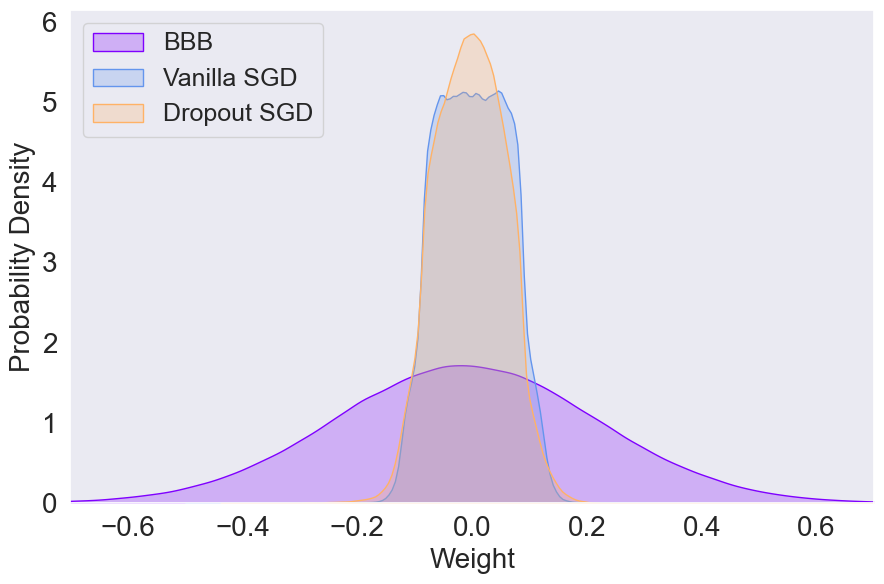

In [30]:
plot_histogram(
        [bnn_weights, dvi_weights], 
        ['BBB', 'DVI']
    )